## Import the modules

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the dataset and randomize it

In [7]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/training_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# labels - age
import random
import shutil


image_paths = []
age_labels = []

files = os.listdir(BASE_DIR)
random.shuffle(files)

for filename in files:
    image_path = os.path.join(BASE_DIR, filename)
    image_paths.append(image_path)

    temp = filename.split('_')

    age = int(temp[0])
    age_labels.append(age)

In [14]:
from sklearn.model_selection import train_test_split

random_seed = 42

image_paths_train, image_paths_test, age_labels_train, age_labels_test = train_test_split(
    image_paths, age_labels, test_size=0.2, random_state=random_seed
)

In [17]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

df_test = pd.DataFrame()
df_test['image'], df_test['age'] = image_paths_test, age_labels_test

## Feature Extraction

In [18]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [31]:
from PIL import Image
X = extract_features(df['image'])
X_test = extract_features(df_test['image'])

  0%|          | 0/8777 [00:00<?, ?it/s]

  0%|          | 0/1756 [00:00<?, ?it/s]

In [20]:
X.shape

(8777, 128, 128, 1)

In [32]:
# normalize
X = X / 255.0
X_test = X_test / 255.0

In [22]:
y_age = np.array(df['age'])
y_age_test = np.array(df_test['age'])

In [23]:
input_shape = (128, 128, 1)

In [24]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_2 = Dense(256, activation='relu') (flatten)

dropout_2 = Dropout(0.3) (dense_2)

output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# train model
history = model.fit(x=X, y=y_age, batch_size=32, epochs=30, validation_split=0.2)

In [26]:
model.save('age_detection_model_no_augmentation_32_30.h5')
!mv age_detection_model_no_augmentation_32_30.h5 /content/drive/MyDrive

55/55 [==============================] - 1s 12ms/step


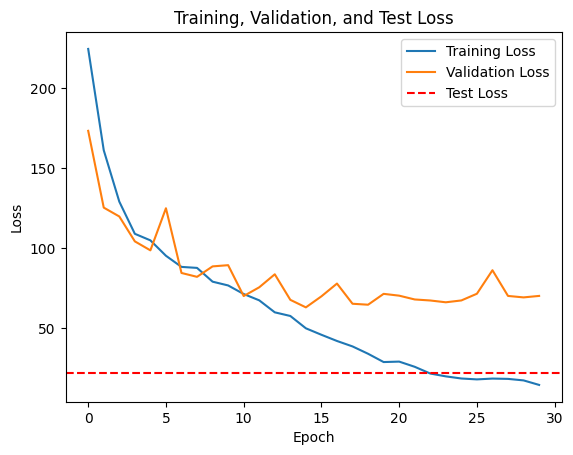

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_predictions = model.predict(X_test)
true_labels = y_age_test

# Calculate the test loss
test_loss = mean_squared_error(test_predictions, true_labels)

# Plot the training loss, validation loss, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()
# OVERFITTING NOT GOOD!!!!

In [ ]:
history2 = model.fit(x=X, y=y_age, batch_size=32, epochs=15, validation_split=0.2)

55/55 [==============================] - 0s 6ms/step


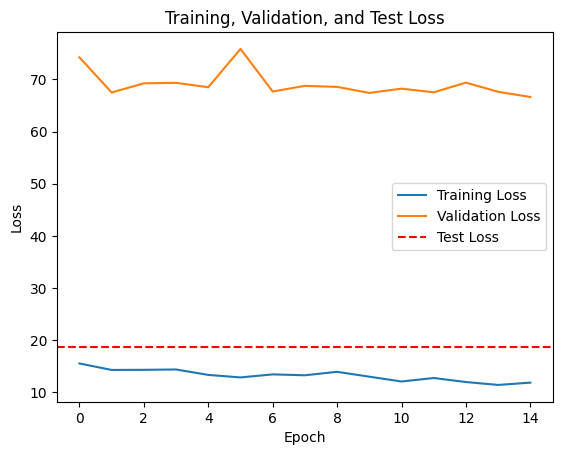

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_predictions = model.predict(X_test)
true_labels = y_age_test

# Calculate the test loss
test_loss = mean_squared_error(test_predictions, true_labels)

# Plot the training loss, validation loss, and test loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()
# POOR!!! Trying other ways to improve such as AUGMENTATION

In [44]:
from keras.layers.experimental import preprocessing
inputs = Input((input_shape))

# Data augmentation layers
data_augmentation = Sequential([
    preprocessing.RandomRotation(factor=0.2),  # Randomly rotate images
    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),  # Randomly zoom images
    preprocessing.RandomFlip(mode='horizontal'),  # Randomly flip images horizontally
])

# Apply data augmentation to the input
augmented_inputs = data_augmentation(inputs)

# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (augmented_inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_2 = Dense(256, activation='relu') (flatten)

dropout_2 = Dropout(0.3) (dense_2)

output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# train model
history3 = model.fit(x=X, y=y_age, batch_size=32, epochs=30, validation_split=0.2)

55/55 [==============================] - 0s 6ms/step


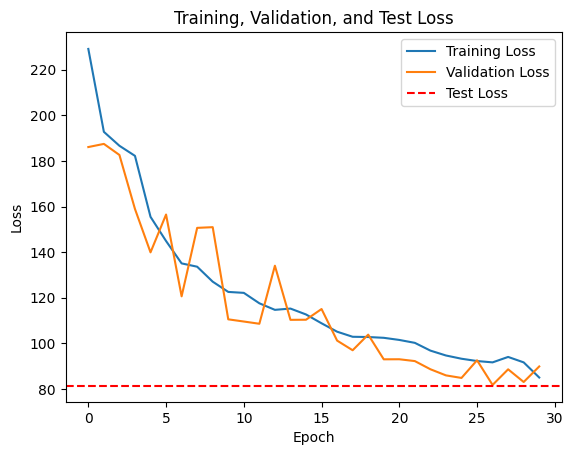

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_predictions = model.predict(X_test)
true_labels = y_age_test

# Calculate the test loss
test_loss = mean_squared_error(test_predictions, true_labels)

# Plot the training loss, validation loss, and test loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()
# The graph seems much better. Overfitting issue at least seems to be resolved.
# But the model gives bad predictions :(

In [47]:
model.save('age_detection_model_augmentation_32_30.h5')
!mv age_detection_model_augmentation_32_30.h5 /content/drive/MyDrive

In [ ]:
# train model
history3 = model.fit(x=X, y=y_age, batch_size=32, epochs=60, validation_split=0.2)

55/55 [==============================] - 0s 6ms/step


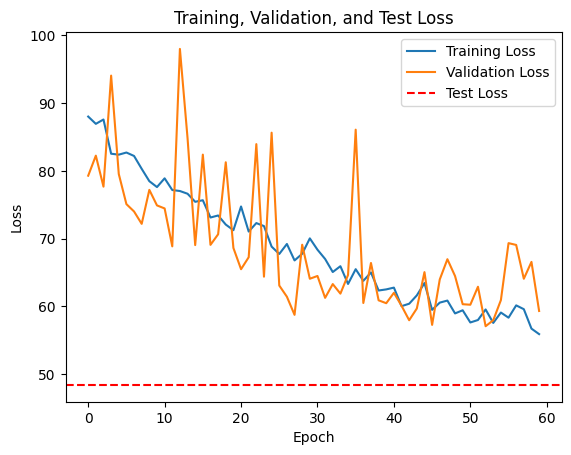

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_predictions = model.predict(X_test)
true_labels = y_age_test

# Calculate the test loss
test_loss = mean_squared_error(test_predictions, true_labels)

# Plot the training loss, validation loss, and test loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()
# Not good, not stable.

In [50]:
model.save('age_detection_model_augmentation_32_60.h5')
!mv age_detection_model_augmentation_32_60.h5 /content/drive/MyDrive

In [ ]:
# train model
history4 = model.fit(x=X, y=y_age, batch_size=16, epochs=30, validation_split=0.2)

55/55 [==============================] - 1s 9ms/step


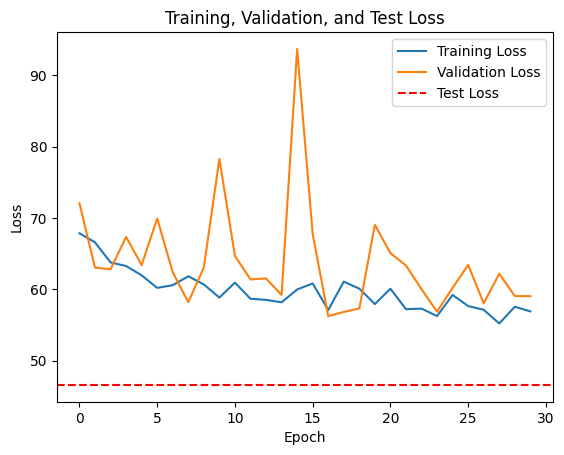

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_predictions = model.predict(X_test)
true_labels = y_age_test

# Calculate the test loss
test_loss = mean_squared_error(test_predictions, true_labels)

# Plot the training loss, validation loss, and test loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()
# Not good, not stable. But this one actually worked fine in real world test.

In [53]:
model.save('age_detection_model_augmentation_16_30.h5')
!mv age_detection_model_augmentation_16_30.h5 /content/drive/MyDrive

In [ ]:
# train model
history5 = model.fit(x=X, y=y_age, batch_size=16, epochs=60, validation_split=0.2)

55/55 [==============================] - 1s 10ms/step


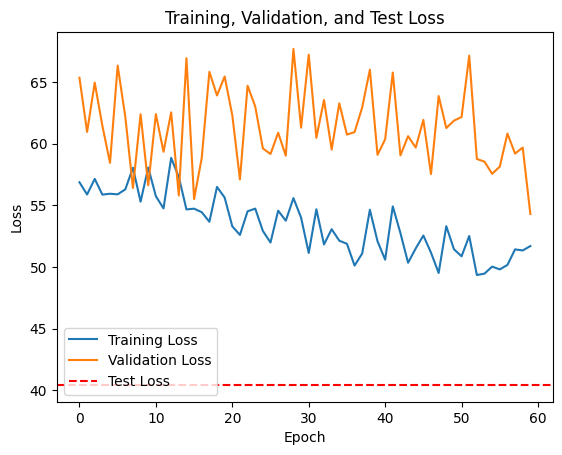

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_predictions = model.predict(X_test)
true_labels = y_age_test

# Calculate the test loss
test_loss = mean_squared_error(test_predictions, true_labels)

# Plot the training loss, validation loss, and test loss
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()
# Not good, very very unstable.

In [56]:
model.save('age_detection_model_augmentation_16_60.h5')
!mv age_detection_model_augmentation_16_60.h5 /content/drive/MyDrive

In [57]:
# My conclusion is that the model with augmentation and 16 batch size and 30 epoch is good enough compared to others.